### Algoritmo K-Nearest Neighbors (KNN) 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Cargar los datos
df_defunciones = pd.read_csv("../defunciones_clean.csv")

# Filtrar causas específicas
causas_objetivo = {
    "Infarto agudo del miocardio, sin otra especificación": "I219",
    "Neumonía, no especificada": "J189",
    "Diabetes mellitus no especificada, sin mención de complicación": "E149"
}
codigos_cie = list(causas_objetivo.values())
df_filtrado = df_defunciones[df_defunciones["causa"].isin(codigos_cie)].copy()

# Limpiar datos
df_filtrado = df_filtrado.drop(columns=['ocupacion'])  # muchas columnas vacías
df_filtrado = df_filtrado.dropna()

# Variables predictoras y objetivo
X = df_filtrado.drop(columns=["causa"])
y = df_filtrado["causa"]

# Columnas numéricas y categóricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Función para entrenar y evaluar con GridSearchCV
def evaluar_knn_con_grid(test_size):
    print(f"\n=== Evaluación para test_size = {int(test_size*100)}% ===")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("knn", KNeighborsClassifier())
    ])

    param_grid = {"knn__n_neighbors": [2, 9, 20, 25]}
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Mejor k encontrado:", grid.best_params_["knn__n_neighbors"])

    y_pred = grid.predict(X_test)
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=causas_objetivo.keys()))

# Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=codigos_cie)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=causas_objetivo.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión (test_size = {test_size})")
    plt.show()

# Ejecutar evaluaciones con diferentes particiones
for ts in [0.3, 0.2, 0.15]:
    evaluar_knn_con_grid(ts)

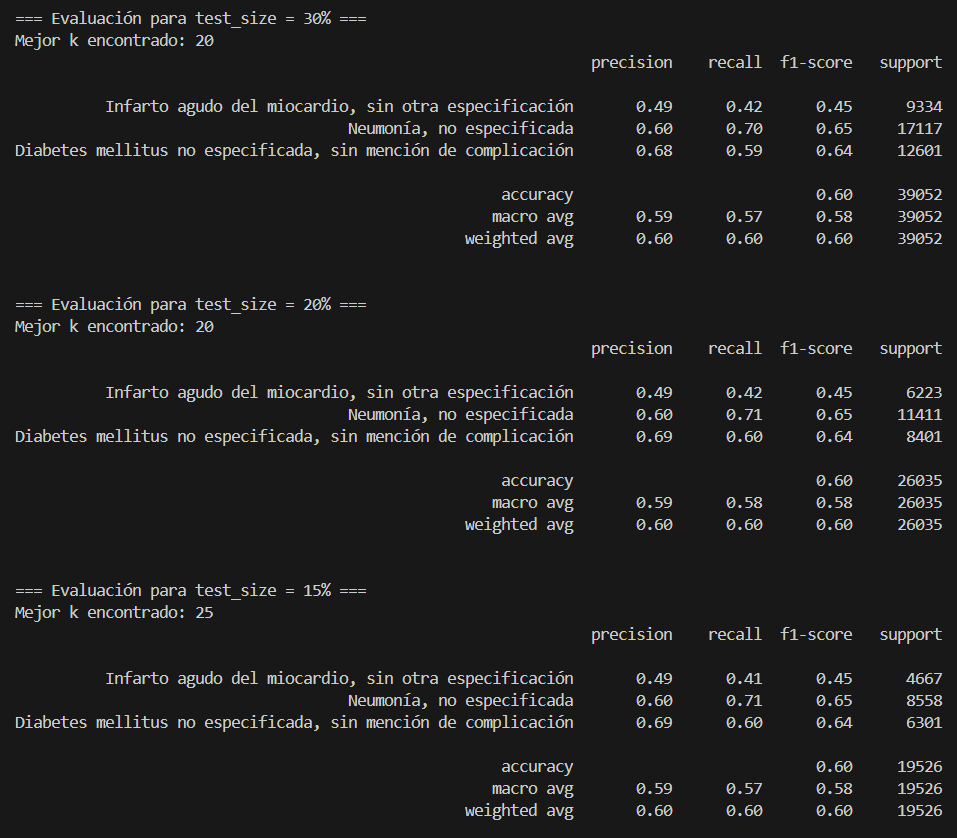

El accuracy general es de 0.60 lo cual indica que el modelo predice correctamente el 60% de los casos en promedio.

En cuanto al F1-score, la clase Neumonia es la que tiene consistentemente el mejor rendimiento con 0.65, la clase infarto es la más difícil de predecir con un valor de 0.45 lo que sugiere una confusión con otras clases, por otro lado la clase diabetes se mantiene estable con 0.64 pero el recall es más bajo que la precisión lo que indica que se pierden varios casos verdaderos.

un weighted avg aproximadamente de 0.60 significa que el modelo está sesgado hacia clases más frecuentes (como "Neumonía").

En conclusión, el modelo tiene un rendimiento aceptable pero limitado, el 60% de accuracy en clasificación multiclase no es malo, es probable que el uso de KNN pueda estar limitado por el tamaño y la dimensionalidad del dataset, ya que es sensible a la escala y no se desempeña bien en datasets demasiado grandes o de alta dimensión.

### Matrices de confusión

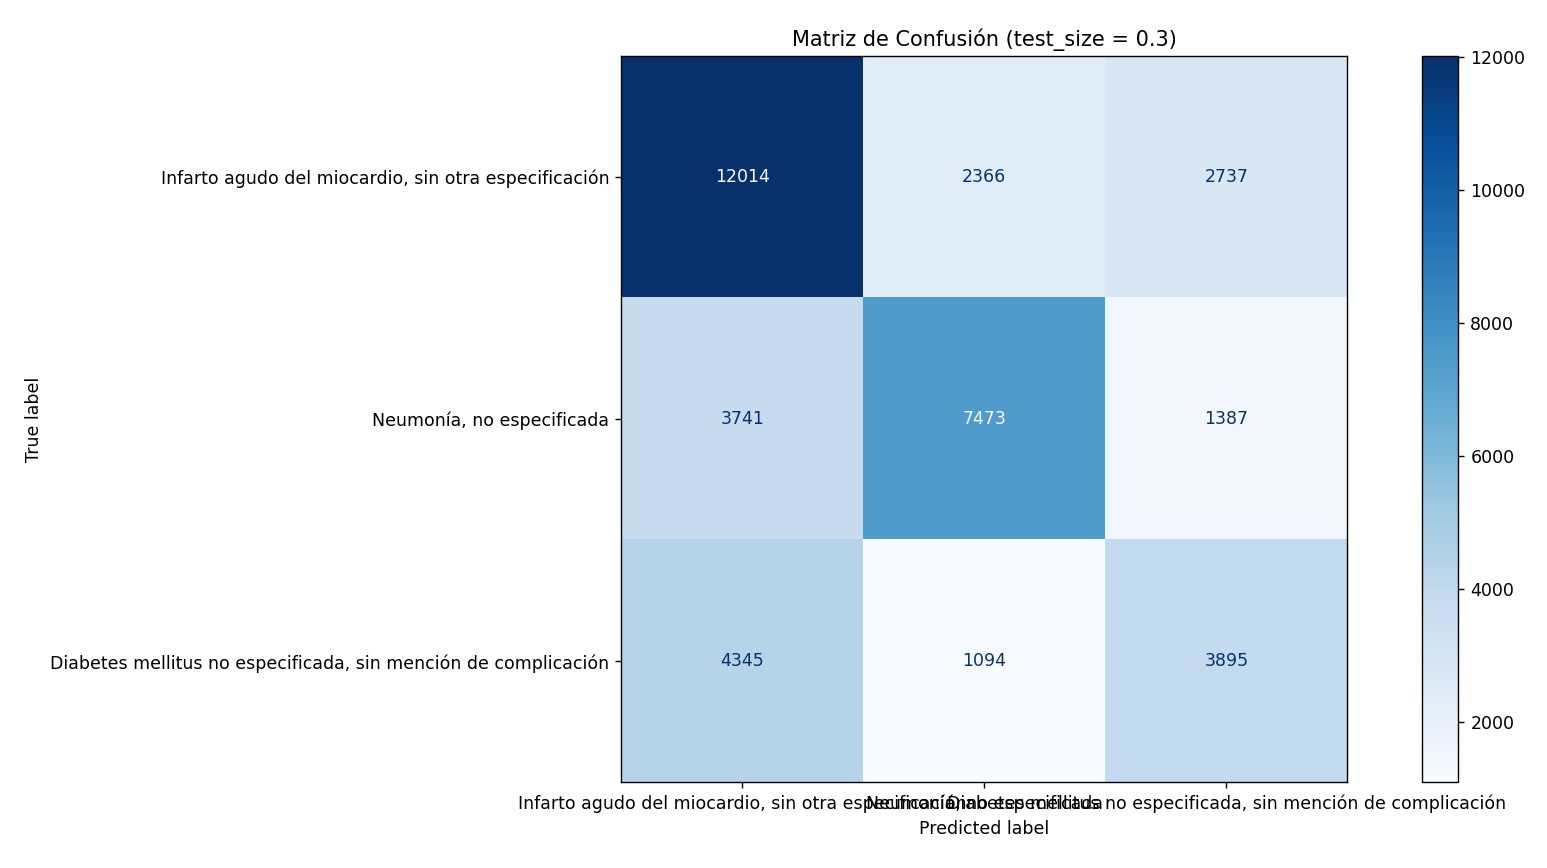
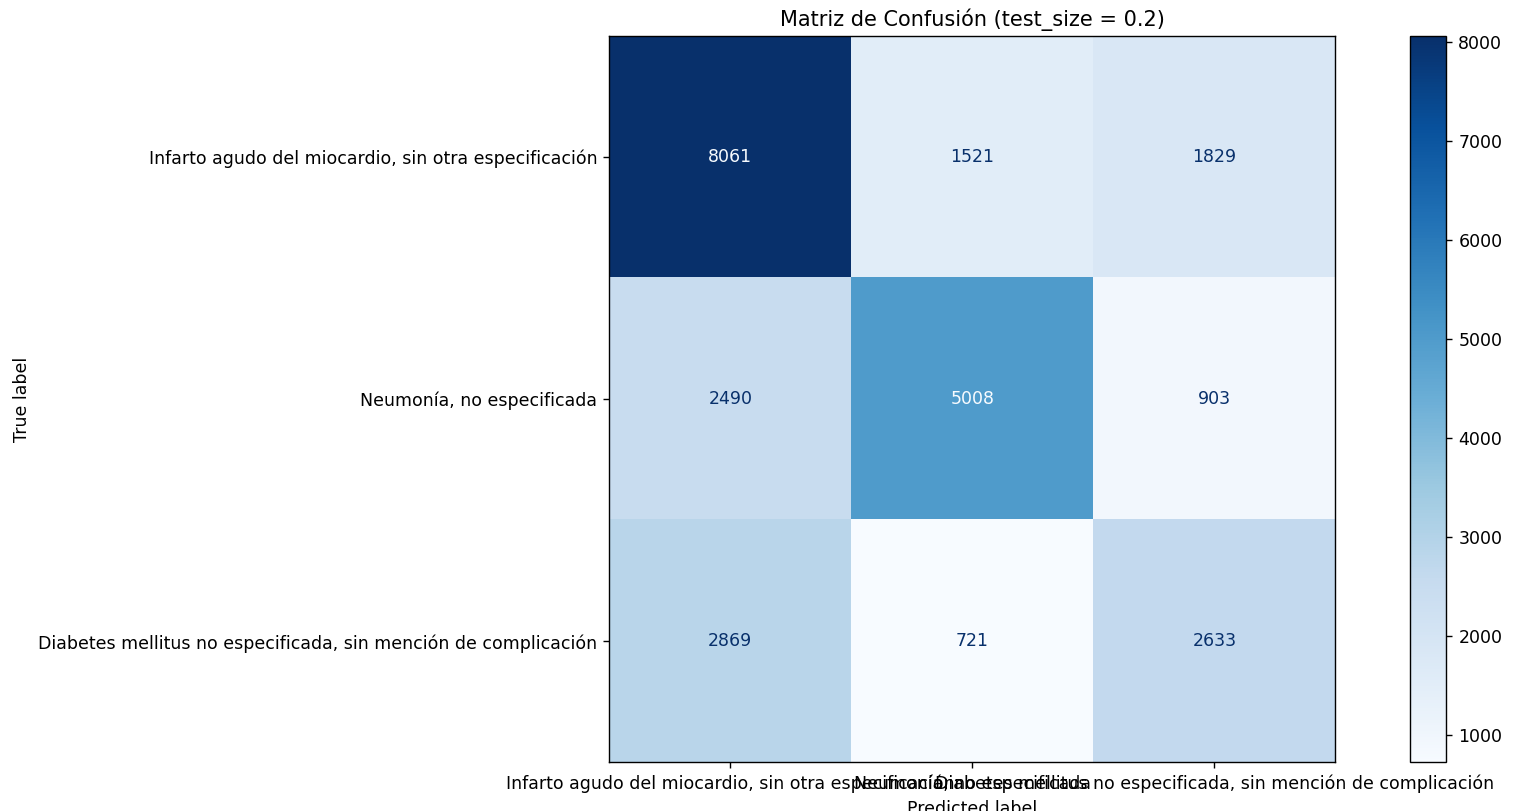
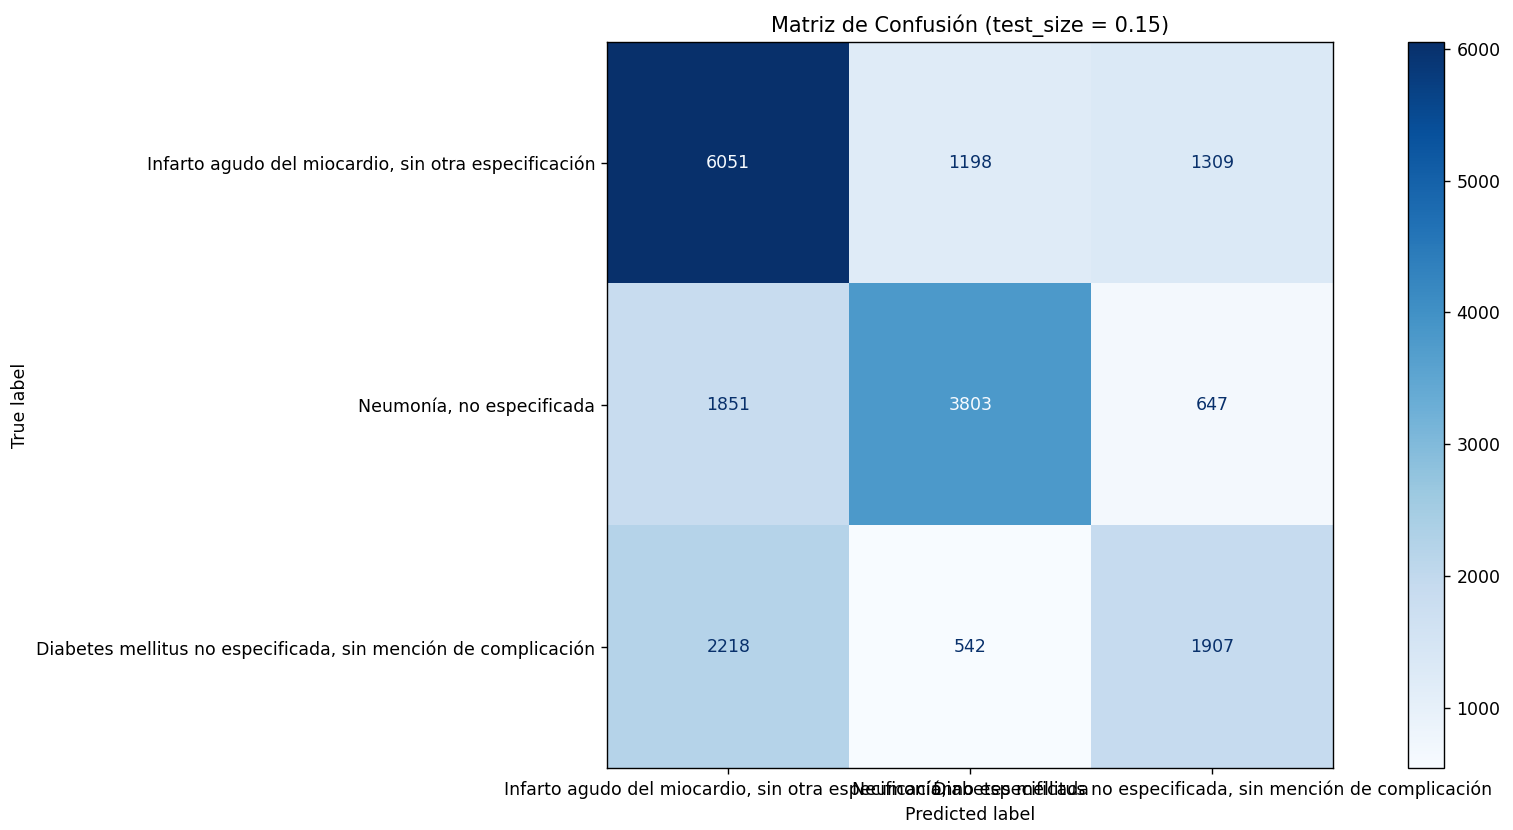